In [7]:
import sys
import scipy
import warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import qptransform as qp
import matplotlib.pyplot as plt

from multiprocessing import Pool, cpu_count
from inject_waveforms import get_timeseries
from pycbc.conversions import mass1_from_mchirp_q, mass2_from_mchirp_q

warnings.filterwarnings("ignore")
params={
    'text.usetex':True,
    'font.family':'serif',
    'xtick.minor.visible':True,
    'ytick.minor.visible':True,
    'xtick.top':True,
    'ytick.left':True,
    'ytick.right':True,
    'xtick.direction':'out',
    'ytick.direction':'out',
    'xtick.minor.size':2.5,
    'xtick.major.size':5,
    'ytick.minor.size':2.5,
    'ytick.major.size':5,
    'axes.axisbelow':True
}
mpl.rcParams.update(params)

In [66]:
def downsample(data):
    times = np.linspace(0, data.duration, len(data.data))
    downsampling=int(np.ceil(np.ceil(1./(times[1]-times[0]))/2048.))
    data_downsampled=scipy.signal.decimate(data.data, downsampling) # downsample data
    times = np.linspace(0, data.duration, len(data_downsampled)+1)
    data_downsampled = qp.TimeSeries(data_downsampled, x0=times[0], dx=times[1]-times[0], copy=False)
    data_downsampled.whiten()
    return data_downsampled

def gen_qptransform(q, mchirp, qrange=None, prange=None):
    m1 = mass1_from_mchirp_q(mchirp, q)
    m2 = mass2_from_mchirp_q(mchirp, q)
    strain, _, inj, _ = get_timeseries(
            m1=m1,
            m2=m2,
            snr=100,
            eccentricity=0.1,
            f_low=20,
        )

    n = int(inj.sample_times[np.argmax(np.abs(inj.data))])+1
    trange = (n - 2, inj.duration - n)
    inj = inj.crop(*trange)
    trange = (n - 2 - strain.start_time, strain.end_time - n)
    strain = strain.crop(*trange)
    data_downsampled = downsample(strain)
    frange=[20., 400.]
    alpha=0.05
    alpha_find_Qp=0.2
    filmethod='highpass_threshold_filtering'
    denoising_threshold=7.


    if qrange is not None:
        print("Using user defined qrange")
        QPINSTANCE=qp.QpTransform(data=data_downsampled, times=data_downsampled.times.value, whiten=False, frange=frange, alpha=alpha, \
            alpha_find_Qp=alpha_find_Qp,denoising_threshold=denoising_threshold,filmethod=filmethod, qrange=qrange)
    elif prange is not None:
        print("Using user defined prange")
        QPINSTANCE=qp.QpTransform(data=data_downsampled, times=data_downsampled.times.value, whiten=False, frange=frange, alpha=alpha, \
            alpha_find_Qp=alpha_find_Qp,denoising_threshold=denoising_threshold,filmethod=filmethod, prange=prange)
    elif qrange is not None and prange is not None:
        print("Using user defined qrange and prange")
        QPINSTANCE=qp.QpTransform(data=data_downsampled, times=data_downsampled.times.value, whiten=False, frange=frange, alpha=alpha, \
            alpha_find_Qp=alpha_find_Qp,denoising_threshold=denoising_threshold,filmethod=filmethod, qrange=qrange, prange=prange)
    else:
        print("Using default qrange and prange")
        QPINSTANCE=qp.QpTransform(data=data_downsampled, times=data_downsampled.times.value, whiten=False, frange=frange, alpha=alpha, \
            alpha_find_Qp=alpha_find_Qp,denoising_threshold=denoising_threshold,filmethod=filmethod)

    return QPINSTANCE

In [5]:
q = np.logspace(-0.5, 0.1, 20)
mchirp = np.linspace(10, 30, 20)

r1 = np.random.randint(0, 20)
r2 = np.random.randint(0, 20)

m1 = mass1_from_mchirp_q(mchirp[r1], q[r2])
m2 = mass2_from_mchirp_q(mchirp[r1], q[r2])

print(f"m1: {m1:.3f}, m2: {m2:.3f}\n q: {q[r2]:.3f}, mchirp: {mchirp[r1]:.3f}")

m1: 14.741, m2: 18.114
 q: 0.814, mchirp: 14.211


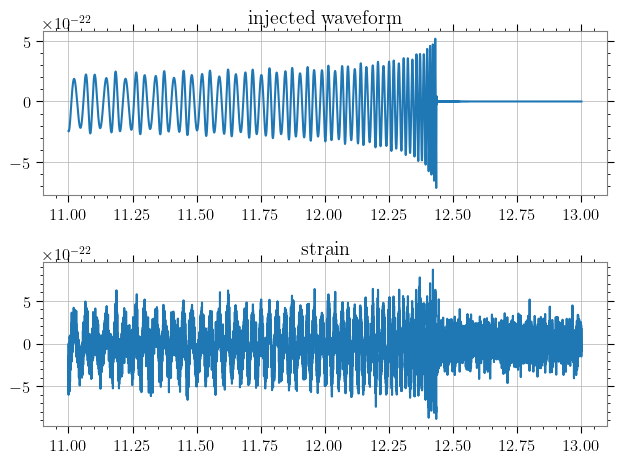

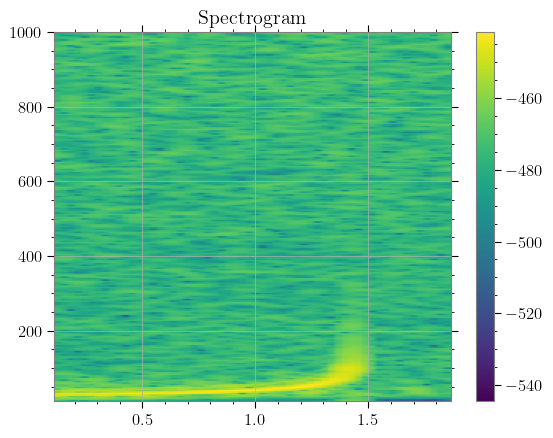

In [6]:
strain, hp, inj, inj1 = get_timeseries(
        m1=m1,
        m2=m2,
        snr=100,
        eccentricity=0.1,
        f_low=20,
    )

n = int(inj.sample_times[np.argmax(np.abs(inj.data))])+1
trange = (n - 2, inj.duration - n)
inj = inj.crop(*trange)
trange = (n - 2 - strain.start_time, strain.end_time - n)
strain = strain.crop(*trange)

plt.subplot(211)
plt.plot(inj.sample_times, inj)
plt.title('injected waveform')
plt.subplot(212, sharex=plt.gca())
plt.plot(strain.sample_times, strain)
plt.title('strain')
plt.tight_layout()
plt.show()

#create spectrogram of the strain using fourier transform
NFFT = 1024  # Length of the windowing segments
Fs = 4096  # The sampling frequency
fig, ax = plt.subplots(1, 1)
Pxx, freqs, bins, im = ax.specgram(strain, NFFT=NFFT, Fs=Fs, noverlap=900)
ax.set_ylim([10, 1000])
fig.colorbar(im, ax=ax)
ax.set_title('Spectrogram')
plt.show()

In [7]:
data_downsampled = downsample(strain)

In [8]:
frange=[20., 400.]
alpha=0.05
alpha_find_Qp=0.2
qrange=[2.*np.pi, 6.*np.pi]
filmethod='highpass_threshold_filtering'
denoising_threshold=7.
energy_density_threshold=7.

QPINSTANCE=qp.QpTransform(data=data_downsampled, times=data_downsampled.times.value, whiten=False, frange=frange, alpha=alpha, alpha_find_Qp=alpha_find_Qp,denoising_threshold=denoising_threshold,filmethod=filmethod)
print(f'Q={round(QPINSTANCE.Q, 8)}\np={round(QPINSTANCE.p,8)}\npeak={QPINSTANCE.peak}\nenergy density={round(QPINSTANCE.energy_density,2)}\narea={round(QPINSTANCE.TF_area,2)}')

Q=27.35994841
p=0.08161129
peak={'energy': 9.166583711217605e-42, 'time': 1.355137825012207, 'frequency': 67.06804522403958}
energy density=0.0
area=0.0


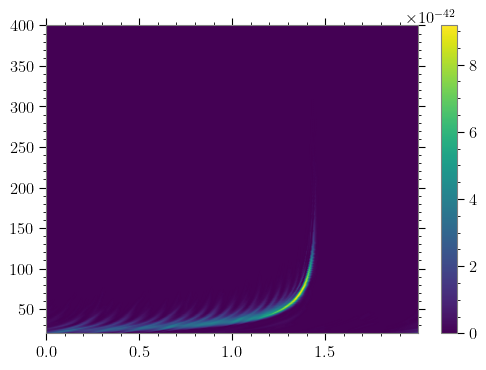

In [9]:
fig, ax = plt.subplots(figsize=(6, 4))
vmax=QPINSTANCE.qpspecgram.max()
ax.pcolormesh(QPINSTANCE.series.times.value-QPINSTANCE.series.times.value[0], QPINSTANCE.qpspecgram.frequencies.value, np.transpose(np.asarray(QPINSTANCE.qpspecgram.value)), vmin=0, vmax=vmax, cmap='viridis', shading='gouraud')
ax.colorbar = plt.colorbar(ax.get_children()[0], ax=ax, orientation='vertical')
ax.grid(False)

# **Multiprocessing**

In [9]:
def run_injections(theta):
    # Unpack the parameters
    mchirp, q = theta

    # Get the masses
    m1, m2 = mass1_from_mchirp_q(mchirp, q), mass2_from_mchirp_q(mchirp, q)

    # Get the time series
    strain, _, inj, _ = get_timeseries(
        m1=m1,
        m2=m2,
        snr=100,
        eccentricity=0.1,
        f_low=20,
    )
    n = int(inj.sample_times[np.argmax(np.abs(inj.data))])+1
    trange = (n - 2 - strain.start_time, strain.end_time - n)
    strain = strain.crop(*trange)
    data_downsampled = downsample(strain)

    # Get the Qp-transform
    frange=[20., 200.]
    alpha=0.05
    alpha_find_Qp=0.2
    filmethod='highpass_threshold_filtering'
    denoising_threshold=7.
    QPINSTANCE=qp.QpTransform(data=data_downsampled, times=data_downsampled.times.value, whiten=False, frange=frange, alpha=alpha, alpha_find_Qp=alpha_find_Qp,denoising_threshold=denoising_threshold,filmethod=filmethod)
    BESTQ = QPINSTANCE.Q
    BESTP = QPINSTANCE.p
    with open('results.csv', 'a') as f:
        for p in np.linspace(0, 0.3, 30):
            qpinstance=qp.QpTransform(data=data_downsampled, times=data_downsampled.times.value, whiten=False, frange=frange, alpha=alpha, alpha_find_Qp=alpha_find_Qp,denoising_threshold=denoising_threshold,filmethod=filmethod, prange=[p,p], qrange=[BESTQ,BESTQ])
            f.write(f'{q};{mchirp};{qpinstance.Q};{p};{BESTQ};{BESTP};{qpinstance.energy_density};{qpinstance.peak}\n')
        for Q in np.linspace(20, 40, 30):
            qpinstance=qp.QpTransform(data=data_downsampled, times=data_downsampled.times.value, whiten=False, frange=frange, alpha=alpha, alpha_find_Qp=alpha_find_Qp,denoising_threshold=denoising_threshold,filmethod=filmethod, qrange=[Q,Q], prange=[BESTP,BESTP])
            f.write(f'{q};{mchirp};{Q};{qpinstance.p};{BESTQ};{BESTP};{qpinstance.energy_density};{qpinstance.peak}\n')

In [10]:
#meshgrid of mchirp and q
grid = np.meshgrid(mchirp, q)
theta = np.array([m.flatten() for m in grid]).T

pool = Pool(cpu_count()-2)
for i, _ in enumerate(pool.imap_unordered(run_injections, theta), 1):
    sys.stderr.write('\rdone {0:%}'.format(i/400))

done 100.000000%

In [52]:
data = pd.read_csv('results.csv', delimiter=';')
data['peak'] = data['peak'].apply(lambda x: eval(x))
energy = []
for row in data.iterrows():
    energy.append(row[1]['peak']['energy'])
data['energy'] = energy

highest_energy_Q = []
highest_energy_P = []
for row in data.iterrows():
    masked = data[(data['q'] == row[1]['q']) & (data['mchirp'] == row[1]['mchirp'])]
    highest_energy_Q.append(masked['Q'][masked['energy'].idxmax()])
    highest_energy_P.append(masked['p'][masked['energy'].idxmax()])
data['highest_energy_Q'] = highest_energy_Q
data['highest_energy_P'] = highest_energy_P

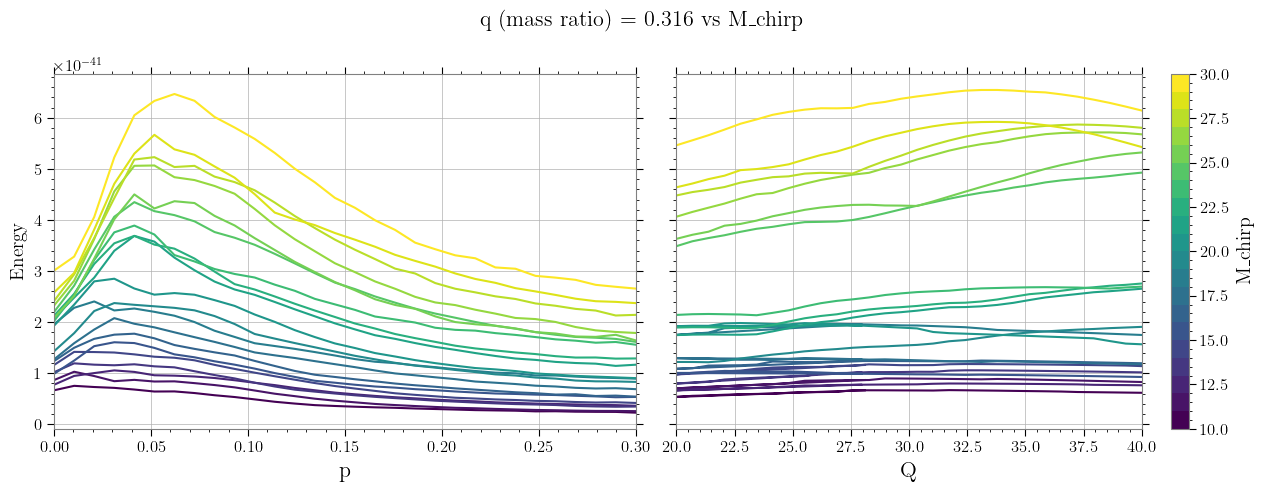

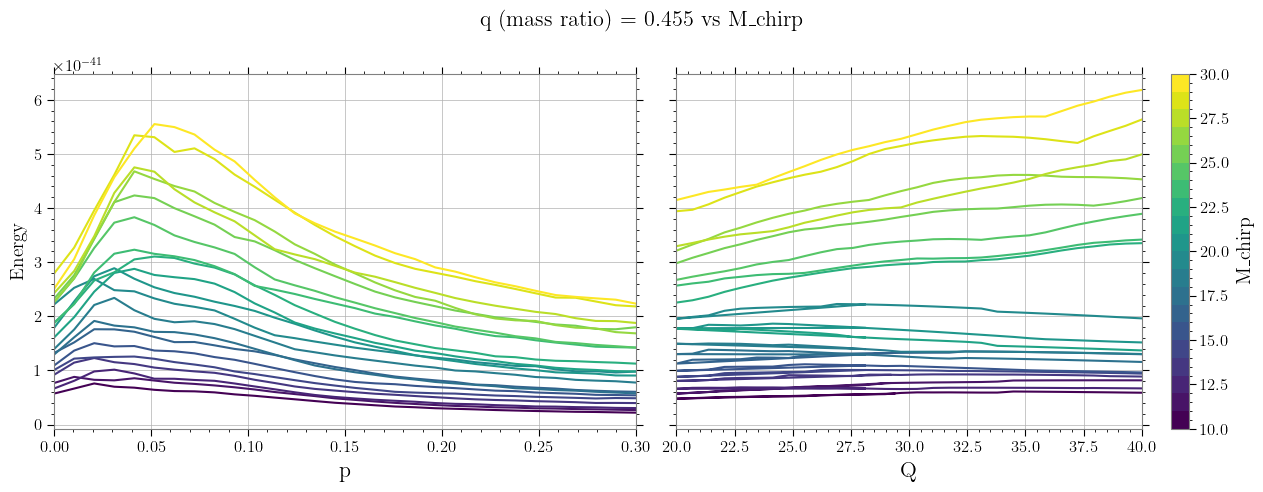

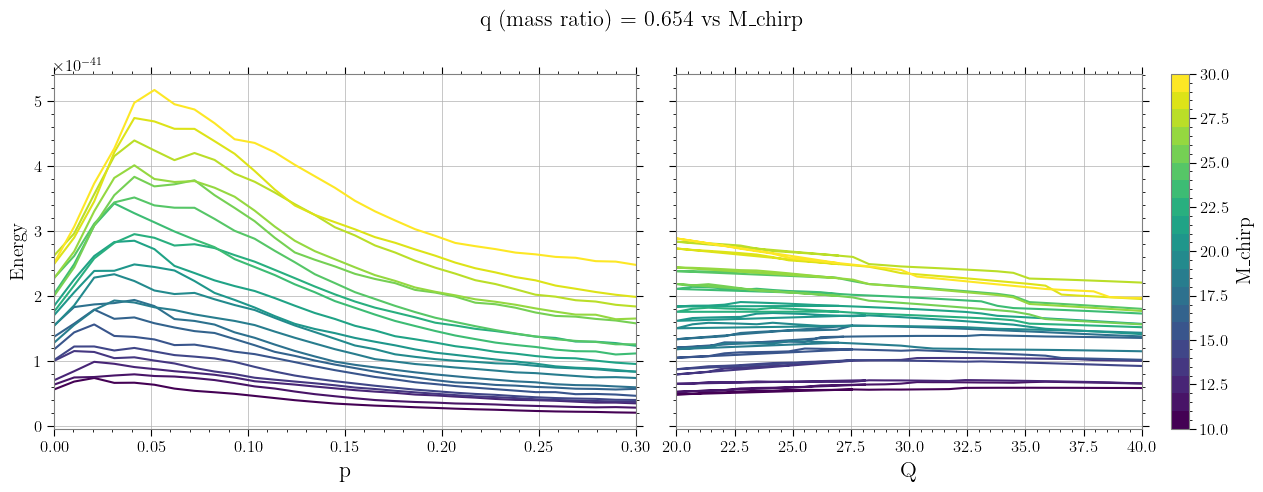

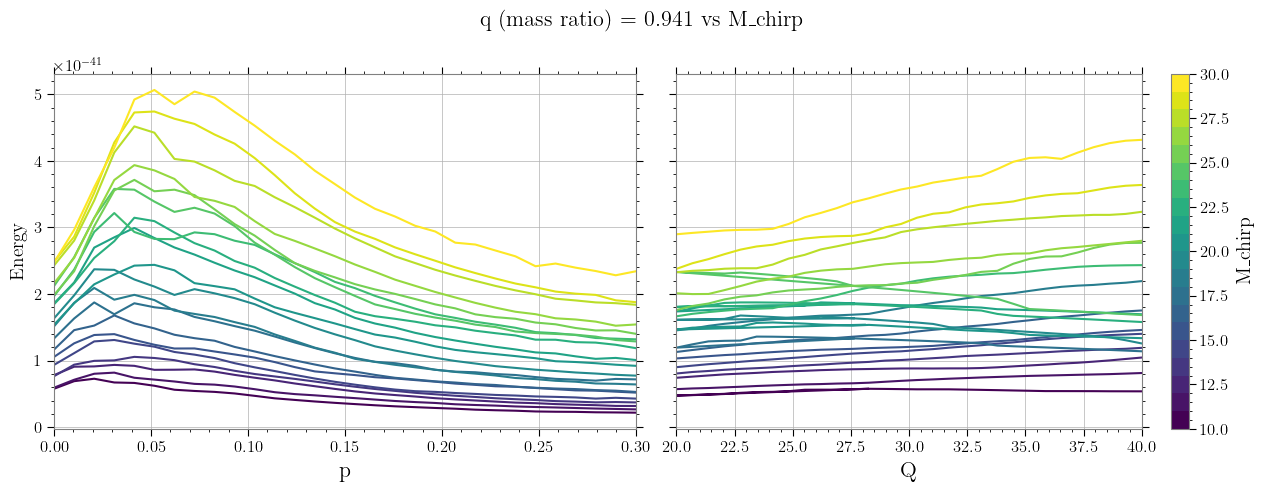

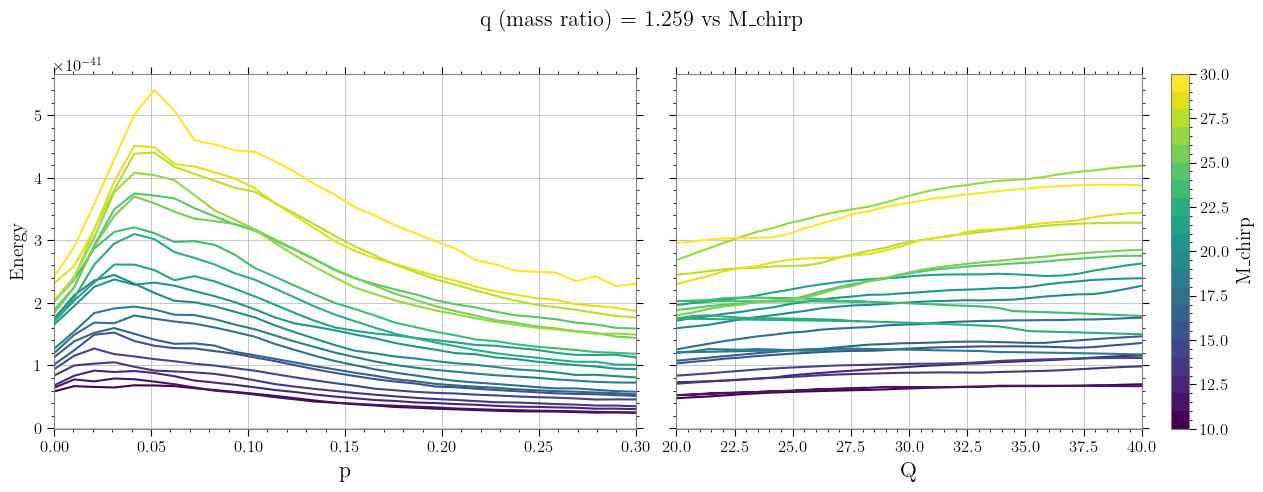

In [15]:
#create colormap with mchrip values
viridis = mpl.colormaps['viridis'].resampled(len(data['mchirp'].unique()))
norm = mpl.colors.Normalize(vmin=min(data['mchirp']), vmax=max(data['mchirp']))

#reduce number of plots
mass_ratios = np.sort(data['q'].unique())
mass_ratios = np.array([mass_ratios[0], mass_ratios[5], mass_ratios[10], mass_ratios[15], mass_ratios[-1]])

for q in mass_ratios:
    fig, ax = plt.subplots(1, 2, figsize=(13, 5), sharey=True)
    for i, mchirp in enumerate(np.sort(data['mchirp'].unique())):
        masked = data[(data['q'] == q) & (data['mchirp'] == mchirp)]
        Qmasked = masked[masked['Q'] == masked['BESTQ']]
        Pmasked = masked[masked['p'] == masked['BESTP']]
        ax[0].plot(Qmasked['p'], Qmasked['energy'],  color=viridis(i))
        ax[1].plot(Pmasked['Q'], Pmasked['energy'],  color=viridis(i))
    fig.colorbar = plt.colorbar(mpl.cm.ScalarMappable(cmap=viridis, norm=norm) , ax=ax[1], orientation='vertical', label='M_chirp')
    ax[0].set_xlabel('p', fontsize=16)
    ax[1].set_xlabel('Q', fontsize=16)
    ax[0].set_ylabel('Energy', fontsize=14)
    ax[0].set_xlim(0, 0.3)
    ax[1].set_xlim(20, 40)
    fig.suptitle(f'q (mass ratio) = {q:.3f} vs M_chirp', fontsize=16)
    fig.tight_layout()

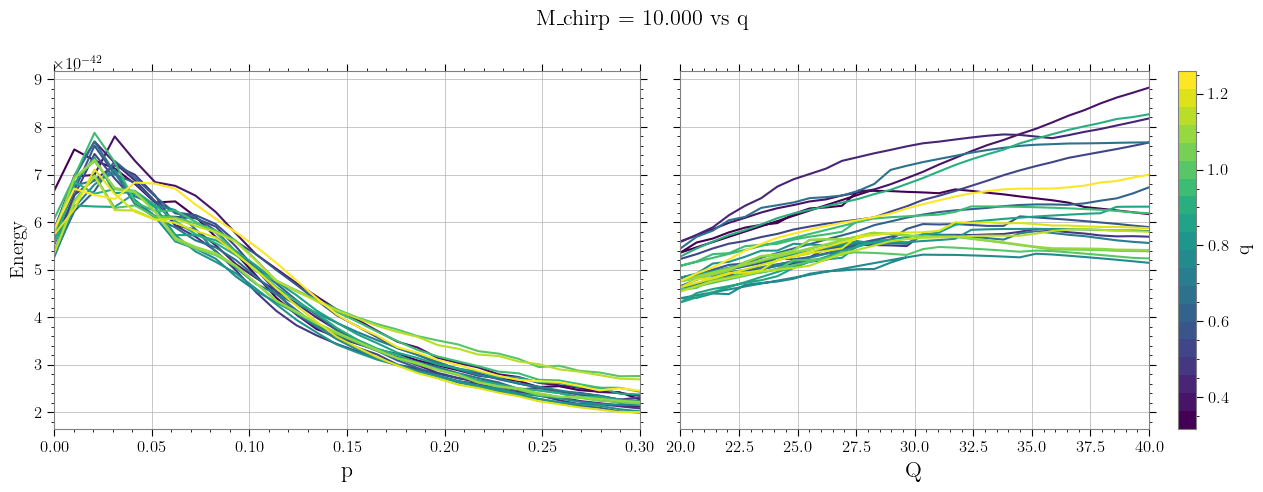

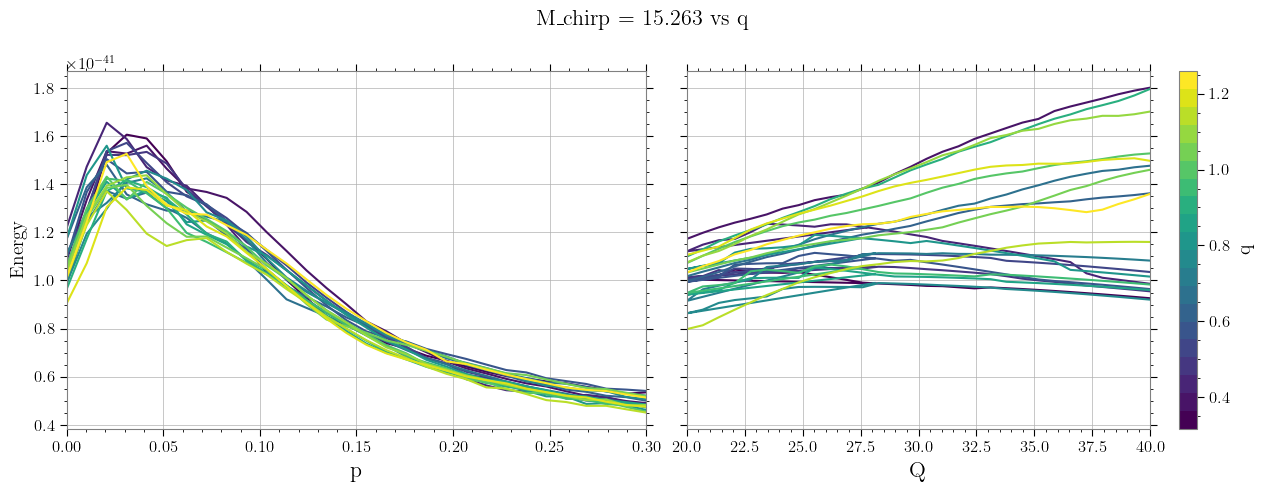

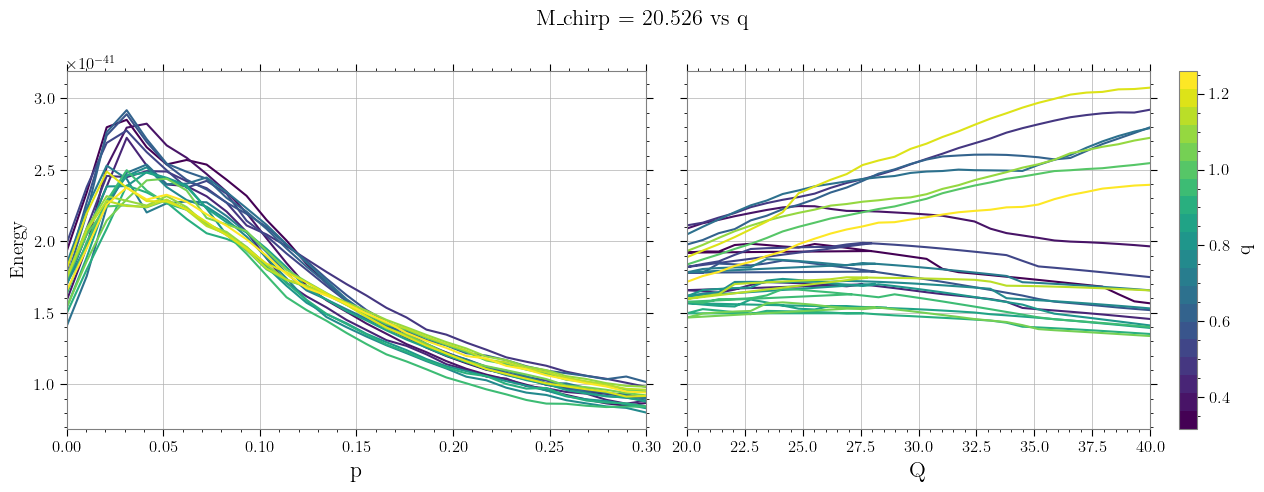

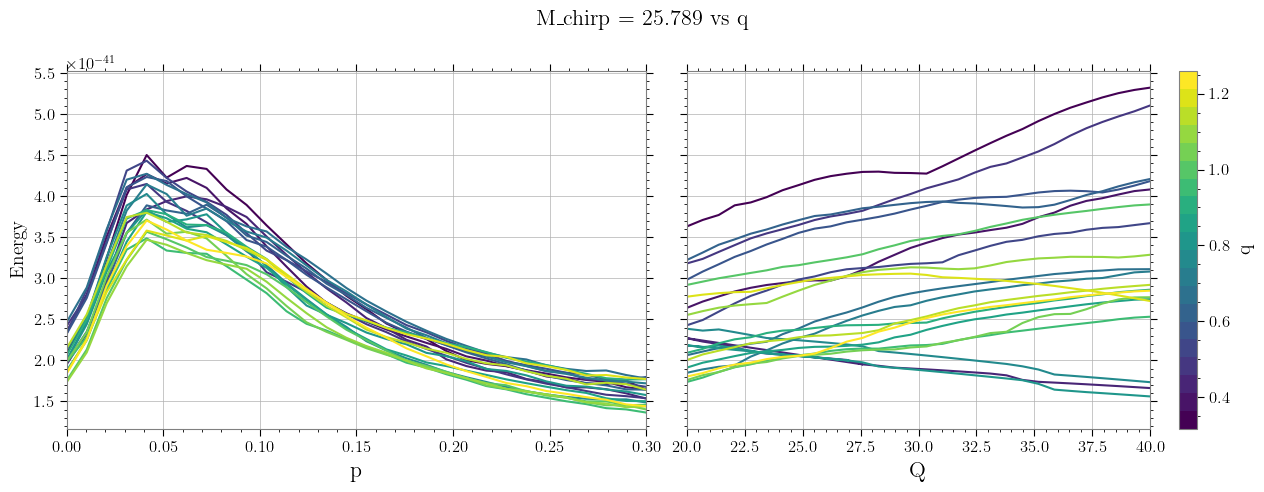

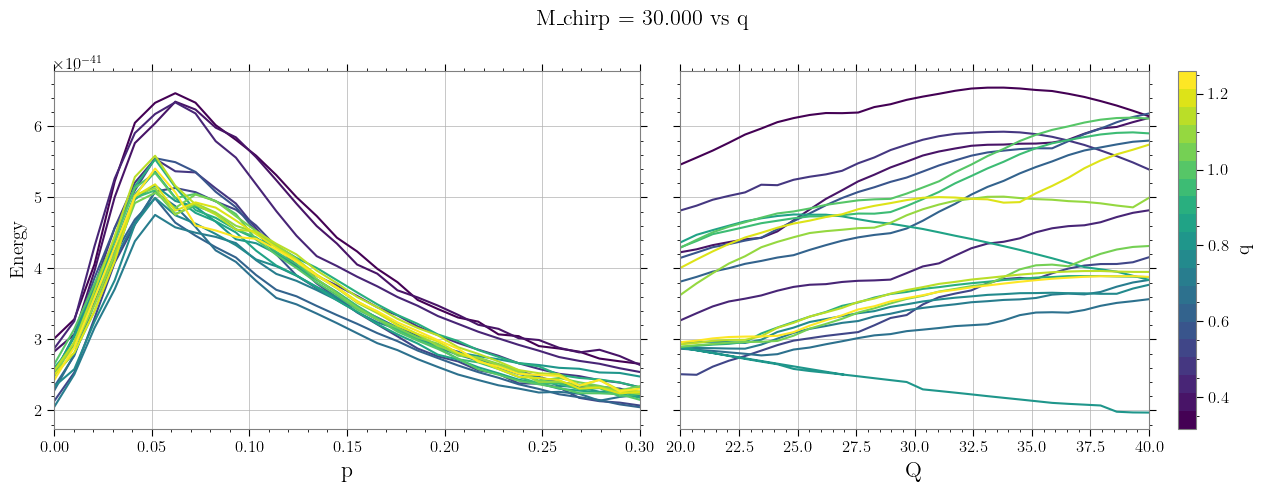

In [16]:
# create colormap with q values
viridis = mpl.colormaps['viridis'].resampled(len(data['q'].unique()))
norm = mpl.colors.Normalize(vmin=min(data['q']), vmax=max(data['q']))

#reduce number of plots
mchirps = np.sort(data['mchirp'].unique())
mchirps = np.array([mchirps[0], mchirps[5], mchirps[10], mchirps[15], mchirps[-1]])

for mchirp in mchirps:
    fig, ax = plt.subplots(1, 2, figsize=(13, 5), sharey=True)
    for i, q in enumerate(np.sort(data['q'].unique())):
        masked = data[(data['mchirp'] == mchirp) & (data['q'] == q)]
        Qmasked = masked[masked['Q'] == masked['BESTQ']]
        Pmasked = masked[masked['p'] == masked['BESTP']]
        ax[0].plot(Qmasked['p'], Qmasked['energy'],  color=viridis(i))
        ax[1].plot(Pmasked['Q'], Pmasked['energy'],  color=viridis(i))
    fig.colorbar = plt.colorbar(mpl.cm.ScalarMappable(cmap=viridis, norm=norm) , ax=ax[1], orientation='vertical', label='q')
    ax[0].set_xlabel('p', fontsize=16)
    ax[1].set_xlabel('Q', fontsize=16)
    ax[0].set_ylabel('Energy', fontsize=14)
    ax[0].set_xlim(0, 0.3)
    ax[1].set_xlim(20, 40)
    fig.suptitle(f'M_chirp = {mchirp:.3f} vs q', fontsize=16)
    fig.tight_layout()
plt.show()

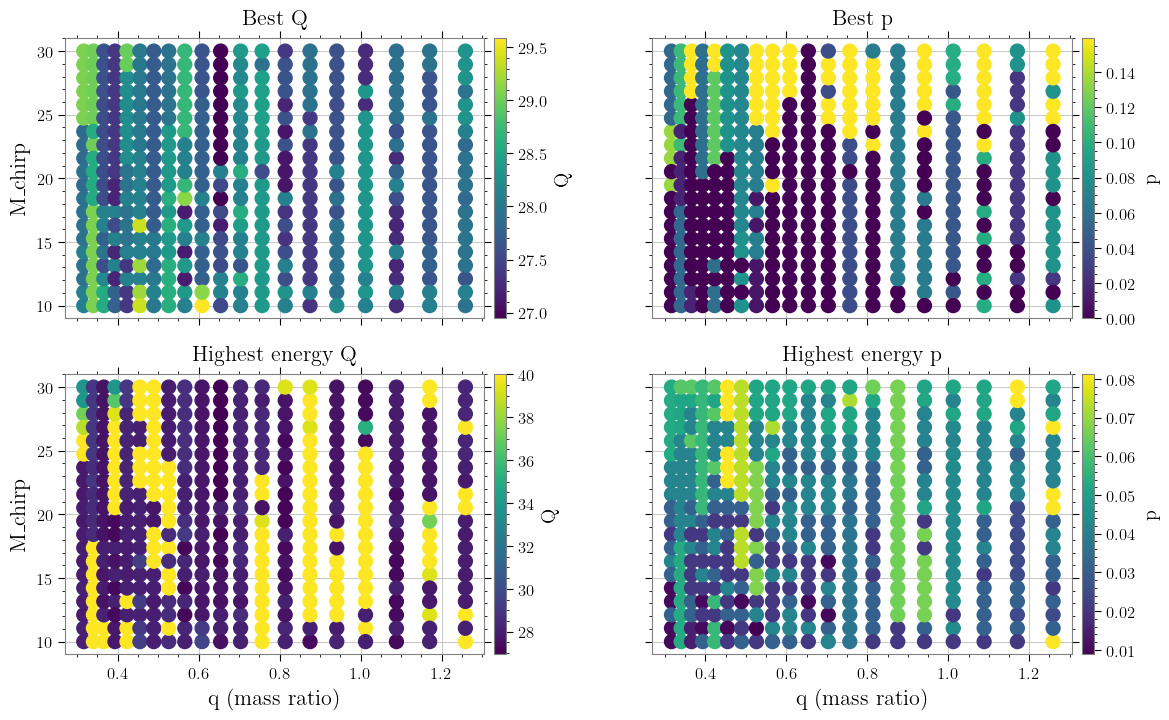

In [56]:
data_filtered = data.drop_duplicates(subset=['q', 'mchirp'])
data_filtered.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots(2, 2, figsize=(13, 8), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.4)


ax[0, 0].scatter(data_filtered['q'], data_filtered['mchirp'], c=data_filtered['BESTQ'], cmap='viridis', s=100)
ax[0, 1].scatter(data_filtered['q'], data_filtered['mchirp'], c=data_filtered['BESTP'], cmap='viridis', s=100)

ax[0, 0].colorbar(label='Q')
ax[0, 1].colorbar(label='p')
ax[0, 0].set_ylabel('M_chirp', fontsize=16)
ax[0, 0].set_title('Best Q', fontsize=16, y=1.02)
ax[0, 1].set_title('Best p', fontsize=16, y=1.02)


ax[1, 0].scatter(data_filtered['q'], data_filtered['mchirp'], c=data_filtered['highest_energy_Q'], cmap='viridis', s=100)
ax[1, 1].scatter(data_filtered['q'], data_filtered['mchirp'], c=data_filtered['highest_energy_P'], cmap='viridis', s=100)

ax[1, 0].colorbar(label='Q')
ax[1, 1].colorbar(label='p')
ax[1, 0].set_xlabel('q (mass ratio)', fontsize=16)
ax[1, 1].set_xlabel('q (mass ratio)', fontsize=16)
ax[1, 0].set_ylabel('M_chirp', fontsize=16)
ax[1, 0].set_title('Highest energy Q', fontsize=16, y=1.02)
ax[1, 1].set_title('Highest energy p', fontsize=16, y=1.02)


plt.show()

Using user defined prange
Using user defined prange


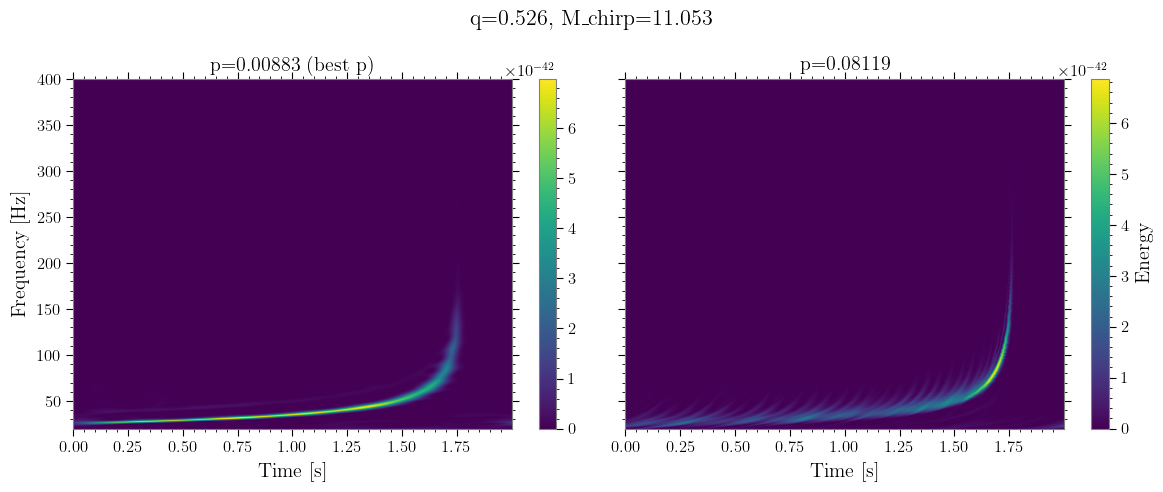

In [77]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
q = data_filtered['q'][data_filtered['highest_energy_P'].idxmin()]
mchirp = data_filtered['mchirp'][data_filtered['highest_energy_P'].idxmin()]


prange = [data_filtered['highest_energy_P'][data_filtered['highest_energy_P'].idxmin()]]*2
QPINSTANCE = gen_qptransform(q, mchirp, prange=prange)

vmax=QPINSTANCE.qpspecgram.max()
ax[0].pcolormesh(QPINSTANCE.series.times.value-QPINSTANCE.series.times.value[0], QPINSTANCE.qpspecgram.frequencies.value, np.transpose(np.asarray(QPINSTANCE.qpspecgram.value)), vmin=0, vmax=vmax, cmap='viridis', shading='gouraud')
ax[0].colorbar = plt.colorbar(ax[0].get_children()[0], ax=ax[0], orientation='vertical')
ax[0].grid(False)
ax[0].set_title(f'p={prange[0]:.5f} (best p)')
ax[0].set_ylabel('Frequency [Hz]')
ax[0].set_xlabel('Time [s]')


prange = [data_filtered['highest_energy_P'][data_filtered['highest_energy_P'].idxmax()]]*2
QPINSTANCE = gen_qptransform(q, mchirp, prange=prange)

vmax=QPINSTANCE.qpspecgram.max()
ax[1].pcolormesh(QPINSTANCE.series.times.value-QPINSTANCE.series.times.value[0], QPINSTANCE.qpspecgram.frequencies.value, np.transpose(np.asarray(QPINSTANCE.qpspecgram.value)), vmin=0, vmax=vmax, cmap='viridis', shading='gouraud')
ax[1].colorbar = plt.colorbar(ax[1].get_children()[0], ax=ax[1], orientation='vertical', label='Energy')
ax[1].grid(False)
ax[1].set_title(f'p={prange[0]:.5f}')
ax[1].set_xlabel('Time [s]')

fig.suptitle(f'q={q:.3f}, M_chirp={mchirp:.3f}', fontsize=16)
fig.tight_layout()
plt.show()

Using user defined prange
Using user defined prange


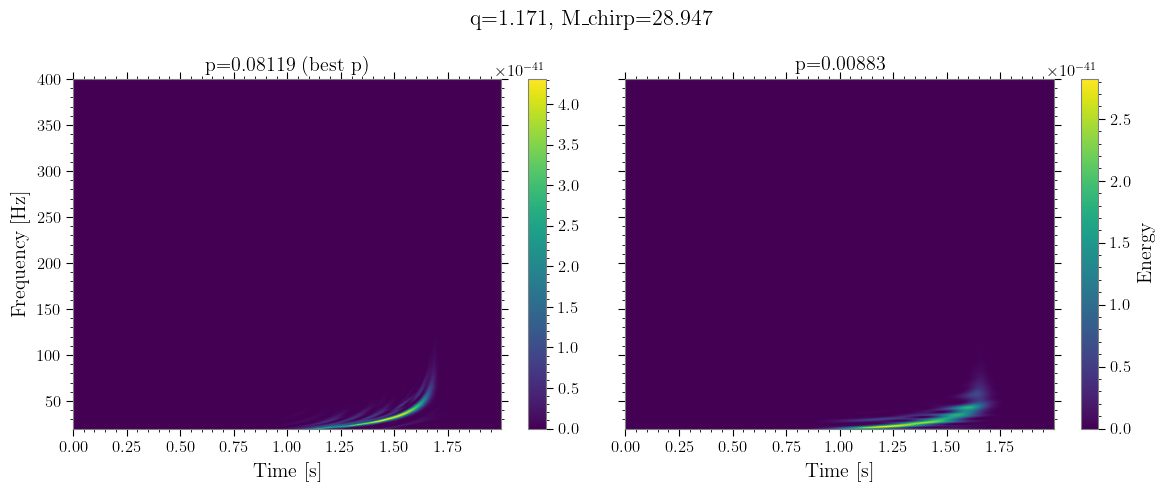

In [78]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
q = data_filtered['q'][data_filtered['highest_energy_P'].idxmax()]
mchirp = data_filtered['mchirp'][data_filtered['highest_energy_P'].idxmax()]


prange = [data_filtered['highest_energy_P'][data_filtered['highest_energy_P'].idxmax()]]*2
QPINSTANCE = gen_qptransform(q, mchirp, prange=prange)

vmax=QPINSTANCE.qpspecgram.max()
ax[0].pcolormesh(QPINSTANCE.series.times.value-QPINSTANCE.series.times.value[0], QPINSTANCE.qpspecgram.frequencies.value, np.transpose(np.asarray(QPINSTANCE.qpspecgram.value)), vmin=0, vmax=vmax, cmap='viridis', shading='gouraud')
ax[0].colorbar = plt.colorbar(ax[0].get_children()[0], ax=ax[0], orientation='vertical')
ax[0].grid(False)
ax[0].set_title(f'p={prange[0]:.5f} (best p)')
ax[0].set_ylabel('Frequency [Hz]')
ax[0].set_xlabel('Time [s]')


prange = [data_filtered['highest_energy_P'][data_filtered['highest_energy_P'].idxmin()]]*2
QPINSTANCE = gen_qptransform(q, mchirp, prange=prange)

vmax=QPINSTANCE.qpspecgram.max()
ax[1].pcolormesh(QPINSTANCE.series.times.value-QPINSTANCE.series.times.value[0], QPINSTANCE.qpspecgram.frequencies.value, np.transpose(np.asarray(QPINSTANCE.qpspecgram.value)), vmin=0, vmax=vmax, cmap='viridis', shading='gouraud')
ax[1].colorbar = plt.colorbar(ax[1].get_children()[0], ax=ax[1], orientation='vertical', label='Energy')
ax[1].grid(False)
ax[1].set_title(f'p={prange[0]:.5f}')
ax[1].set_xlabel('Time [s]')

fig.suptitle(f'q={q:.3f}, M_chirp={mchirp:.3f}', fontsize=16)
fig.tight_layout()
plt.show()